In [6]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
import matplotlib.pyplot as plt


# Define paths to your dataset
train_data_dir = "D:/DATASET/CNN/inflammation/train"
validation_data_dir = "D:/DATASET/CNN/inflammation/val"
test_data_dir ="D:/DATASET/CNN/inflammation/test"

# Define image dimensions
img_width, img_height = 299, 299
input_shape = (img_width, img_height, 3)  # RGB channels

# Define batch size
batch_size = 32

In [7]:
# Data augmentation and normalization
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

validation_datagen = ImageDataGenerator(rescale=1. / 255)

test_datagen = ImageDataGenerator(rescale=1. / 255)

In [8]:
# Load and augment training data
train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical')

# Load validation data
validation_generator = validation_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical')

# Load test data
test_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical')

# Load pre-trained ResNet50 model without including top layers
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)

Found 9732 images belonging to 3 classes.
Found 491 images belonging to 3 classes.
Found 491 images belonging to 3 classes.


In [9]:
# Add custom layers on top of ResNet50
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(3, activation='softmax')(x)  # Output layer with 3 classes (NASH scores 0, 1, 2)

# Model
model = Model(inputs=base_model.input, outputs=predictions)

# Freeze pre-trained layers
for layer in base_model.layers:
    layer.trainable = False

In [10]:
# Compile model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Fine-tune the model
model.fit(train_generator, epochs=3)

# Unfreeze some layers in the base model
for layer in base_model.layers[-10:]:
    layer.trainable = True

# Recompile the model to apply changes
model.compile(optimizer=Adam(lr=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# Train model
model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size,
    epochs=10)


Epoch 1/3
305/305 [==============================] - 1066s 3s/step - loss: 0.8646 - accuracy: 0.6957
Epoch 2/3
305/305 [==============================] - 1218s 4s/step - loss: 0.7944 - accuracy: 0.7114
Epoch 3/3
305/305 [==============================] - 1281s 4s/step - loss: 0.7855 - accuracy: 0.7136


Epoch 1/10
304/304 [==============================] - 1513s 5s/step - loss: 0.7881 - accuracy: 0.7106 - val_loss: 0.8286 - val_accuracy: 0.6938
Epoch 2/10
304/304 [==============================] - 1338s 4s/step - loss: 0.7535 - accuracy: 0.7141 - val_loss: 0.8579 - val_accuracy: 0.6938
Epoch 3/10
304/304 [==============================] - 1309s 4s/step - loss: 0.7381 - accuracy: 0.7188 - val_loss: 1.0046 - val_accuracy: 0.7063
Epoch 4/10
304/304 [==============================] - 1310s 4s/step - loss: 0.7182 - accuracy: 0.7269 - val_loss: 0.8034 - val_accuracy: 0.6521
Epoch 5/10
304/304 [==============================] - 1340s 4s/step - loss: 0.6985 - accuracy: 0.7310 - val_loss: 1.9734 - val_accuracy: 0.1437
Epoch 6/10
304/304 [==============================] - 1408s 5s/step - loss: 0.6877 - accuracy: 0.7359 - val_loss: 0.8255 - val_accuracy: 0.6771
Epoch 7/10
304/304 [==============================] - 1325s 4s/step - loss: 0.6801 - accuracy: 0.7389 - val_loss: 1.9912 - val_accuracy:

In [11]:
# Save the model using TensorFlow's built-in method
model.save('D:/DATASET/Models/model_inflammation.h5')

# Load the model using TensorFlow's built-in method
#loaded_model = tf.keras.models.load_model('D:/DATASET/Models/model_inflammation.h5')


In [12]:
# Evaluate model on test data
test_loss, test_accuracy = model.evaluate(test_generator)
print("Test Accuracy:", test_accuracy)

16/16 [==============================] - 61s 4s/step - loss: 1.0018 - accuracy: 0.5845
Test Accuracy: 0.5845214128494263


In [13]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img

In [20]:
# Function to preprocess the image for highlighting inflammatory foci
def preprocess_image(image):
    # Convert image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Enhance contrast
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    enhanced = clahe.apply(gray)
    
    # Apply thresholding to highlight foci
    _, thresh = cv2.threshold(enhanced, 150, 255, cv2.THRESH_BINARY)
    
    return thresh

# Function to crop image into smaller patches and predict NASH score for each patch
import os

def predict_nash_score_patches(image, patch_size=(299, 299), stride=100, save_dir='patches'):
    img_height, img_width = image.shape[:2]
    scores = []

    if not os.path.exists(save_dir):
        os.makedirs(save_dir)

    for y in range(0, img_height - patch_size[1] + 1, stride):
        for x in range(0, img_width - patch_size[0] + 1, stride):
            patch = image[y:y+patch_size[1], x:x+patch_size[0]]
            if patch.shape[0] == patch_size[1] and patch.shape[1] == patch_size[0]:
                # Save patch image
                patch_save_path = os.path.join(save_dir, f'patch_{y}_{x}.jpg')
                cv2.imwrite(patch_save_path, patch)
                
                # Convert grayscale patch to RGB
                patch_rgb = cv2.cvtColor(patch, cv2.COLOR_GRAY2RGB)
                
                # Preprocess patch for prediction
                processed_patch = preprocess_input(patch_rgb)
                processed_patch = np.expand_dims(processed_patch, axis=0)  # Add batch dimension
                prediction = model.predict(processed_patch)
                scores.append(np.argmax(prediction))

    avg_score = np.mean(scores)
    return avg_score

import matplotlib.pyplot as plt

def visualize_patches(save_dir):
    patch_files = os.listdir(save_dir)

    fig, axes = plt.subplots(3, 3, figsize=(10, 10))
    for i, patch_file in enumerate(patch_files[:9]):
        img_path = os.path.join(save_dir, patch_file)
        patch_img = cv2.imread(img_path)
        axes[i//3, i%3].imshow(cv2.cvtColor(patch_img, cv2.COLOR_BGR2RGB))
        axes[i//3, i%3].axis('off')
        axes[i//3, i%3].set_title(patch_file)
    plt.show()


#Function to process the entire image and obtain the average score
def predict_average_nash_score(image_path):
    # Load and preprocess the input image
    input_image = cv2.imread(image_path)
    preprocessed_image = preprocess_image(input_image)
    
    # Predict NASH scores for patches
    average_score = predict_nash_score_patches(preprocessed_image)
    return int(np.round(average_score, 0))

1/1 [==============================] - 0s 237ms/step
Average NASH Score: 0


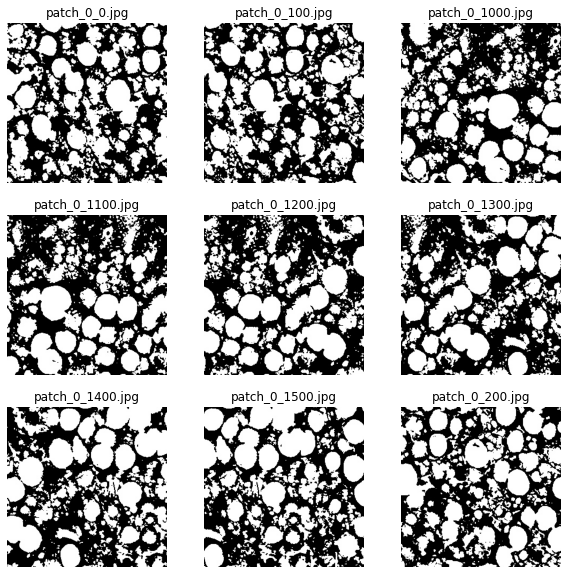

In [21]:
# Example usage:
input_image_path = "D:/Testing (Triya ma'am)/Hematoxylin eosin staining for scoring at 20X and 40x/NASH_40X/4.jpeg"
average_score = predict_average_nash_score(input_image_path)
print("Average NASH Score:", average_score)
# Call the function to visualize the patches
visualize_patches('patches')